# This notebook solves mesh recognition problem

In [1]:
import numpy as np
import random

seed = 42
np.random.seed(seed)
random.seed(seed)

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras import initializers
from keras import callbacks

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
import os
import glob

def count_files(dir, cat=''):
    npy_wildcard = dir + os.sep + '**' + os.sep + '{}*.npy'.format(cat)
    return len(glob.glob(npy_wildcard, recursive=True))

dataset_path = 'Dataset_800'
dataset_train_path = dataset_path + os.sep + 'train'
dataset_validation_path = dataset_path + os.sep + 'validation'
dataset_test_path = dataset_path + os.sep + 'test'

batch_size = 30
batches_per_epoch = 15 
num_epochs = count_files(dataset_train_path) // (batch_size * batches_per_epoch) + 1
image_rows = 64
image_cols = 160

classes = ['bed', 'chair', 'dresser', 'monitor', 'table', 'sofa', 'toilet']
num_classes = len(classes)
model_name = '{}_class'.format(num_classes)

use_saved_model = os.path.exists(model_name + '.h5')

In [3]:
from PIL import Image

def show_bars(y, labels):
    plt.figure(figsize=(20,10))
    plt.rc('xtick', labelsize=18)
    plt.rc('ytick', labelsize=18)
    plt.bar(range(len(y)), y, align='center')
    plt.xticks(range(len(labels)), labels)
    plt.show()

def show_image(npy):
    image = Image.fromarray(npy * 255.0)
    image = image.convert('L')
    plt.imshow(image, cmap='gray')
    plt.show()

def show_weights(layer, root_n):
    layer_weights = layer.get_weights()[0][:,:,0,:]
    plt.xticks([])
    plt.yticks([])
    for i in range(1, root_n * root_n):
        plt.subplot(root_n, root_n, i)
        plt.imshow(layer_weights[:,:,i], interpolation="nearest", cmap="gray")
    plt.show()

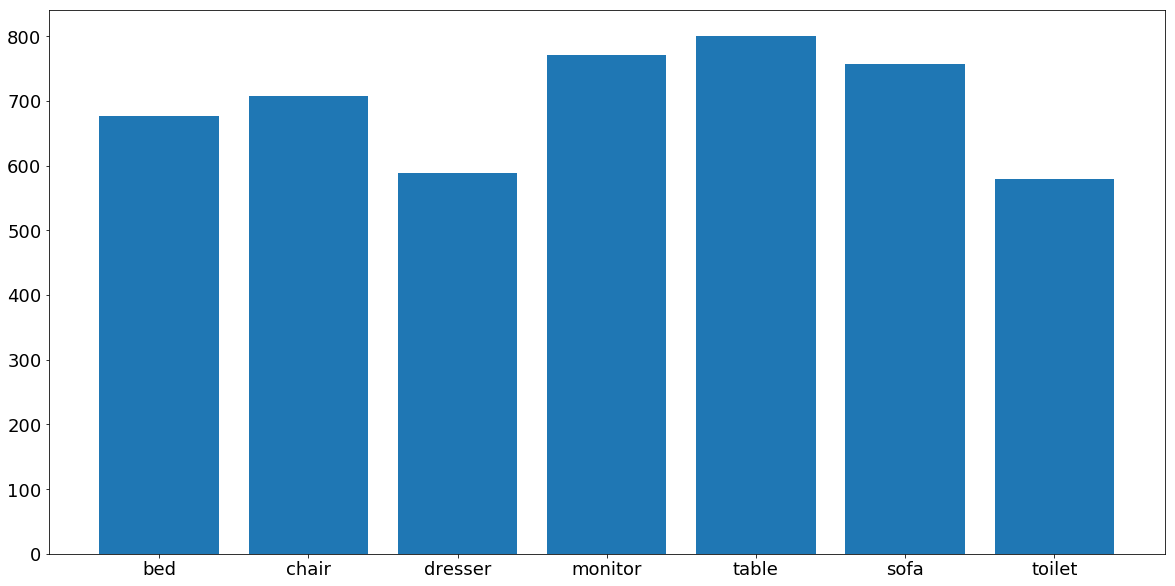

In [4]:
num_files = []
for i in range(len(classes)):
    num_files.append(count_files(dataset_path, classes[i]))

show_bars(num_files, classes)

In [5]:
from npy_generator import *

if not use_saved_model:
    train_generator = npy_generator(dataset_train_path, batch_size, image_rows, image_cols, classes)
    val_generator = npy_generator(dataset_validation_path, batch_size, image_rows, image_cols, classes)

In [6]:
if not use_saved_model:
    optimizer = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

In [7]:
import keras.backend as K

def precision(y_true, y_pred):
    """Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fbeta_score(y_true, y_pred, beta=1):
    """Computes the F score.
    The F score is the weighted harmonic mean of precision and recall.
    Here it is only computed as a batch-wise average, not globally.
    This is useful for multi-label classification, where input samples can be
    classified as sets of labels. By only using accuracy (precision) a model
    would achieve a perfect score by simply assigning every class to every
    input. In order to avoid this, a metric should penalize incorrect class
    assignments as well (recall). The F-beta score (ranged from 0.0 to 1.0)
    computes this, as a weighted mean of the proportion of correct class
    assignments vs. the proportion of incorrect class assignments.
    With beta = 1, this is equivalent to a F-measure. With beta < 1, assigning
    correct classes becomes more important, and with beta > 1 the metric is
    instead weighted towards penalizing incorrect class assignments.
    """
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')

    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score


def fmeasure(y_true, y_pred):
    """Computes the f-measure, the harmonic mean of precision and recall.
    Here it is only computed as a batch-wise average, not globally.
    """
    return fbeta_score(y_true, y_pred, beta=1)

## Model definition

In [8]:
if not use_saved_model:
    model = Sequential()

    model.add(Conv2D(96, kernel_size=(5, 5),
                     activation='relu',
                     input_shape=(image_rows, image_cols, 1),
                     kernel_initializer=initializers.glorot_normal(seed),
                     bias_initializer=initializers.glorot_uniform(seed),
                     padding='same',
                     name='conv_1'))
    #model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same', name='max_pool1'))

    model.add(Conv2D(256, (5, 5), activation='relu',
                     kernel_initializer=initializers.glorot_normal(seed),
                     bias_initializer=initializers.glorot_uniform(seed),
                     padding='same', name='conv_2'))
    #model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same', name='max_pool2'))

    model.add(Conv2D(384, (3, 3), activation='relu',
                     kernel_initializer=initializers.glorot_normal(seed),
                     bias_initializer=initializers.glorot_uniform(seed),
                     padding='same', name='conv_3'))
    #model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same', name='max_pool_3'))

    model.add(Conv2D(512, (3, 3), activation='relu',
                     kernel_initializer=initializers.glorot_normal(seed),
                     bias_initializer=initializers.glorot_uniform(seed),
                     padding='same', name='conv_4'))
    #model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same', name='max_pool_4'))

    model.add(MaxPooling2D(pool_size=(1, 10), padding='same', name='rwmp'))
    
    model.add(Flatten(name='flatten1'))
    model.add(Dense(1024, activation='relu',
                    kernel_initializer='uniform',
                    bias_initializer='uniform',
                    name='dense_1'))
    model.add(Dropout(0.5, name='dropout_1'))
    model.add(Dense(512, activation='relu',
                    kernel_initializer='uniform',
                    bias_initializer='uniform',
                    name='dense_2'))
    model.add(Dropout(0.5, name='dropout_2'))
    model.add(Dense(num_classes, activation='softmax',
                    kernel_initializer='uniform',
                    bias_initializer='uniform',
                    name='output'))

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=optimizer,
                  metrics=[keras.metrics.categorical_accuracy, fmeasure, precision, recall],
                  verbose=2)

In [9]:
if not use_saved_model:
    model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 64, 160, 96)       2496      
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 32, 80, 96)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 32, 80, 256)       614656    
_________________________________________________________________
max_pool2 (MaxPooling2D)     (None, 16, 40, 256)       0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 16, 40, 384)       885120    
_________________________________________________________________
max_pool_3 (MaxPooling2D)    (None, 8, 20, 384)        0         
_________________________________________________________________
conv_4 (Conv2D)              (None, 8, 20, 512)        1769984   
__________

In [10]:
if not use_saved_model:
    checkpointer = callbacks.ModelCheckpoint(model_name + '.h5',
                                   monitor='val_categorical_accuracy',
                                   verbose=2,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='max',
                                   period=1)
    reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss',
                                            factor=0.5, patience=2,
                                            verbose=1, mode='auto',
                                            epsilon=0.0001,
                                            cooldown=0, min_lr=0)

toilet
(64, 160)


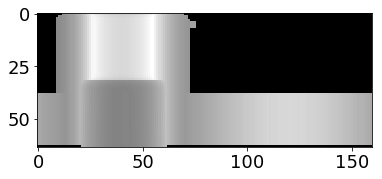

In [11]:
gen = npy_generator(dataset_train_path, batch_size, image_rows, image_cols, classes)
generated = next(gen)
img = generated[0]
label = generated[1][0]
print(classes[np.argmax(label)])
print(img[0, :, :, 0].shape)
plt.imshow(img[0, :, :, 0] * 255, cmap='gray')
plt.show()

## Model training

In [12]:
%%time
if not use_saved_model:
    history = model.fit_generator(
                        train_generator,
                        steps_per_epoch=batches_per_epoch,
                        epochs=num_epochs,
                        validation_data=val_generator,
                        validation_steps=count_files(dataset_validation_path) // batch_size + 1,
                        callbacks=[checkpointer, reduce_lr])

/home/vlad/anaconda3/envs/py35/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:2124: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Epoch 1/9
15/15 [==============================] - 177s - loss: 2.1677 - categorical_accuracy: 0.1533 - fmeasure: 0.0068 - precision: 0.0069 - recall: 0.0067 - val_loss: 2.0016 - val_categorical_accuracy: 0.1619 - val_fmeasure: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/9
15/15 [==============================] - 175s - loss: 1.9416 - categorical_accuracy: 0.1756 - fmeasure: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.7916 - val_categorical_accuracy: 0.3524 - val_fmeasure: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/9
15/15 [==============================] - 177s - loss: 1.5577 - categorical_accuracy: 0.4000 - fmeasure: 0.2086 - precision: 0.3570 - recall: 0.1511 - val_loss: 1.1808 - val_categorical_accuracy: 0.5143 - val_fmeasure: 0.3649 - val_precision: 0.5912 - val_recall: 0.2683
Epoch 4/9
15/15 [==============================] - 178s - loss: 1.2070 - categorical_accuracy: 0.5467 - fmeasure: 0.3963 - p

dict_keys(['val_loss', 'val_precision', 'val_categorical_accuracy', 'val_fmeasure', 'fmeasure', 'val_recall', 'categorical_accuracy', 'loss', 'precision', 'lr', 'recall'])


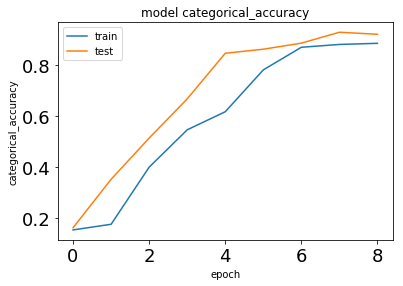

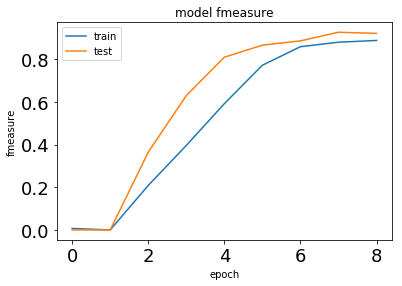

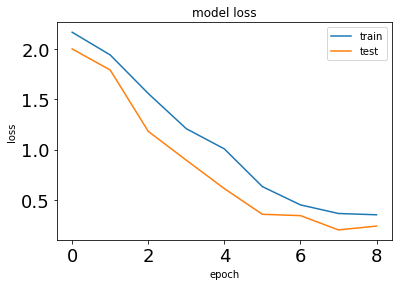

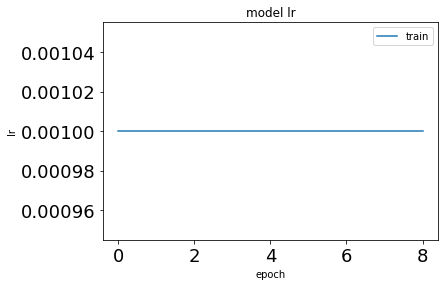

In [13]:
if not use_saved_model:
    print(history.history.keys())
    
    def show_history_for(name, plot_val=True):
        # summarize history for accuracy
        plt.plot(history.history[name])
        if plot_val:
            plt.plot(history.history['val_' + name])
        plt.title('model ' + name)
        plt.ylabel(name)
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='best')
        plt.show()
    
    show_history_for('categorical_accuracy')
    show_history_for('fmeasure')
    show_history_for('loss')
    show_history_for('lr', plot_val=False)

## Loading checkpointed model

In [14]:
model = keras.models.load_model(model_name + '.h5', custom_objects={'fmeasure': fmeasure, 'precision': precision, 'recall': recall})

# Freeze model's weights from training during evaluation
for layer in model.layers:
    layer.trainable = False

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 64, 160, 96)       2496      
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 32, 80, 96)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 32, 80, 256)       614656    
_________________________________________________________________
max_pool2 (MaxPooling2D)     (None, 16, 40, 256)       0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 16, 40, 384)       885120    
_________________________________________________________________
max_pool_3 (MaxPooling2D)    (None, 8, 20, 384)        0         
_________________________________________________________________
conv_4 (Conv2D)              (None, 8, 20, 512)        1769984   
__________

In [16]:
model.get_config()

[{'class_name': 'Conv2D',
  'config': {'activation': 'relu',
   'activity_regularizer': None,
   'batch_input_shape': (None, 64, 160, 1),
   'bias_constraint': None,
   'bias_initializer': {'class_name': 'VarianceScaling',
    'config': {'distribution': 'uniform',
     'mode': 'fan_avg',
     'scale': 1.0,
     'seed': 42}},
   'bias_regularizer': None,
   'data_format': 'channels_last',
   'dilation_rate': (1, 1),
   'dtype': 'float32',
   'filters': 96,
   'kernel_constraint': None,
   'kernel_initializer': {'class_name': 'VarianceScaling',
    'config': {'distribution': 'normal',
     'mode': 'fan_avg',
     'scale': 1.0,
     'seed': 42}},
   'kernel_regularizer': None,
   'kernel_size': (5, 5),
   'name': 'conv_1',
   'padding': 'same',
   'strides': (1, 1),
   'trainable': False,
   'use_bias': True}},
 {'class_name': 'MaxPooling2D',
  'config': {'data_format': 'channels_last',
   'name': 'max_pool1',
   'padding': 'same',
   'pool_size': (2, 2),
   'strides': (2, 2),
   'trainab

## Calculating metrics on the test dataset

In [17]:
test_generator = npy_generator(dataset_test_path, 1, image_rows, image_cols, classes)
print(model.metrics_names)
model.evaluate_generator(test_generator, steps=count_files(dataset_test_path))

['loss', 'categorical_accuracy', 'fmeasure', 'precision', 'recall']


[0.28863482632929666,
 0.90444810543657328,
 0.89621071289163057,
 0.89621076630996122,
 0.89621076630996122]

## Collect true and predicted labels on test dataset 

In [18]:
def collect_labels(dataset_path):
    lim = count_files(dataset_path)
    generator = npy_generator(dataset_path, 1, image_rows, image_cols, classes)
    
    true_labels = np.zeros((0, len(classes)))
    pred_labels = np.empty((0, len(classes)))
    for i in range(lim):
        item = next(generator)
        true_label = item[1]
        true_labels = np.vstack((true_labels, true_label))
        
        sample = item[0]
        pred_label = model.predict(sample, batch_size=1)
        pred_labels = np.vstack((pred_labels,pred_label))
    return true_labels, pred_labels

test_true_labels, test_pred_labels = collect_labels(dataset_test_path)

## Calculate a lot of different metrics

In [19]:
from sklearn import metrics

def report(true_labels, pred_labels):
    print(metrics.classification_report(true_labels, pred_labels, target_names=classes))

report(np.argmax(test_true_labels, axis=1), np.argmax(test_pred_labels, axis=1))

             precision    recall  f1-score   support

        bed       0.85      0.80      0.82        84
      chair       0.86      0.94      0.90        88
    dresser       0.90      0.97      0.93        73
    monitor       0.94      0.89      0.91        96
      table       0.99      0.97      0.98       100
       sofa       1.00      0.90      0.95        94
     toilet       0.76      0.85      0.80        72

avg / total       0.91      0.90      0.91       607



In [20]:
def category_accuracy():
    accuracies = []
    for category in classes:
        cat_path = dataset_test_path + os.sep + category
        cat_generator = npy_generator(cat_path, 1, image_rows, image_cols, classes)
        loss_acc = model.evaluate_generator(cat_generator, steps=count_files(cat_path))
        acc = loss_acc[1]
        accuracies.append(acc)
    return accuracies

accuracies = category_accuracy()

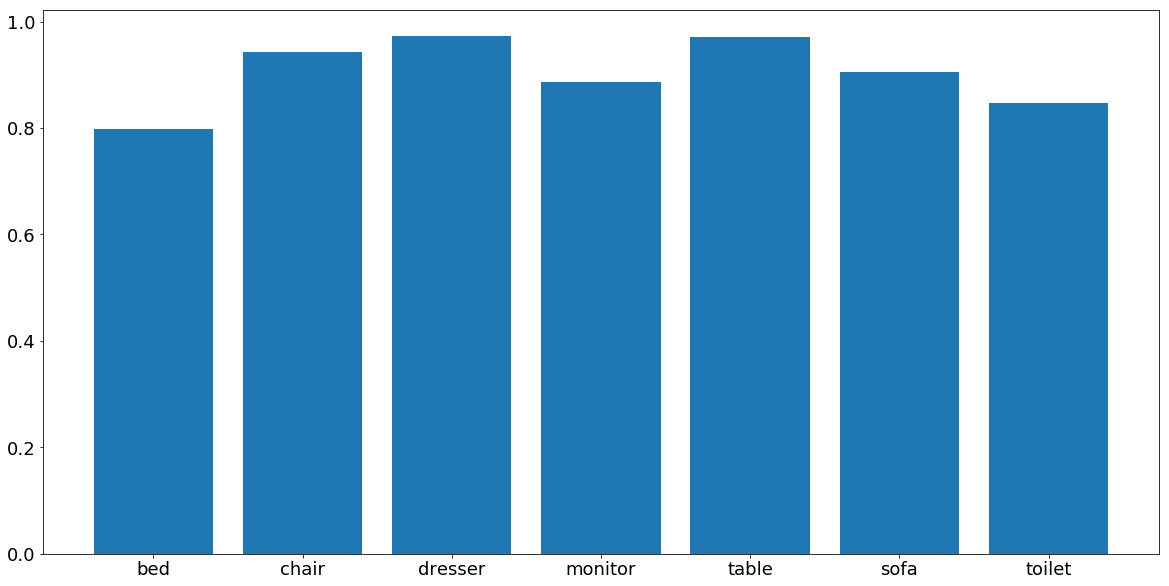

['bed', 'chair', 'dresser', 'monitor', 'table', 'sofa', 'toilet']
[0.79761904761904767, 0.94318181818181823, 0.9726027397260274, 0.88541666666666663, 0.96999999999999997, 0.9042553191489362, 0.84722222222222221]


In [21]:
show_bars(accuracies, classes)
print(classes)
print(accuracies)

## If network predicts correctly then check how sure is it in average

In [22]:
def category_confidence():
    def compute_confidence(probs, class_idx):
        def take_correctly_predicted(probs, class_idx):
            return probs[np.argmax(probs, axis=1) == class_idx, :]
        
        correct = take_correctly_predicted(probs, class_idx)
        return np.mean(correct[:, class_idx])

    confidences = []
    for i in range(len(classes)):
        category = classes[i]
        cat_path = dataset_test_path + os.sep + category
        cat_generator = npy_generator(cat_path, 1, image_rows, image_cols, classes)
        
        probs = model.predict_generator(cat_generator, steps=count_files(cat_path))
        confidences.append(compute_confidence(probs, i))
        
    return confidences

confidences = category_confidence()

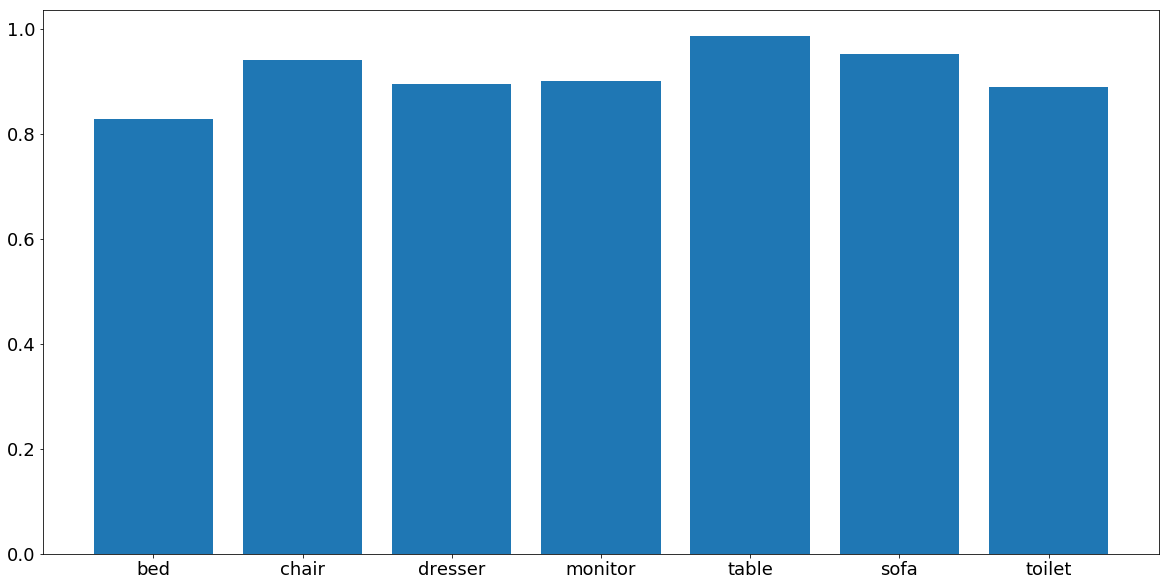

['bed', 'chair', 'dresser', 'monitor', 'table', 'sofa', 'toilet']
[0.82749903, 0.94070041, 0.89541113, 0.90032214, 0.98583722, 0.95137733, 0.88895994]


In [23]:
show_bars(confidences, classes)
print(classes)
print(confidences)

## Play around with the model

In [24]:
from scipy import misc
from cylinder_projection import *
import trimesh

def what_is_this_npy(filepath):
    npy = np.load(filepath)
    
    show_image(npy)
    
    data = np.empty((1, image_rows, image_cols, 1))
    data[0, :, :, 0] = npy
    
    probabilities = model.predict(data, batch_size=1, verbose=2)
    return classes[np.argmax(probabilities)], probabilities

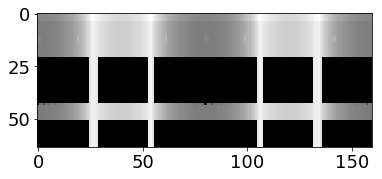

('table', array([[  1.73308610e-04,   3.35623808e-02,   9.07559588e-04,
           9.35273594e-04,   9.63259161e-01,   1.97728237e-04,
           9.64526262e-04]], dtype=float32))

In [25]:
what_is_this_npy(dataset_test_path + os.sep + 'table' + os.sep + 'table_0055.npy')

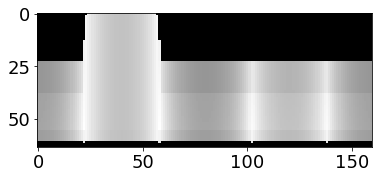

('bed', array([[  8.55899870e-01,   3.63988499e-03,   5.68586728e-03,
           6.24286069e-04,   6.41655861e-05,   6.90097688e-04,
           1.33395731e-01]], dtype=float32))

In [26]:
what_is_this_npy(dataset_test_path + os.sep + 'bed' + os.sep + 'bed_0101.npy')

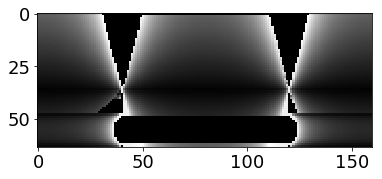

('monitor',
 array([[ 0.00134767,  0.03576552,  0.00215272,  0.62240112,  0.33468103,
          0.00290499,  0.00074692]], dtype=float32))

In [27]:
what_is_this_npy(dataset_test_path + os.sep + 'monitor' + os.sep + 'monitor_0249.npy')

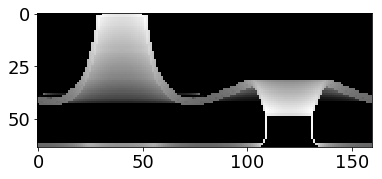

('chair', array([[  3.69209535e-02,   9.43442762e-01,   2.48246331e-04,
           6.08336460e-03,   5.93512924e-03,   3.40001192e-04,
           7.02959625e-03]], dtype=float32))

In [28]:
what_is_this_npy(dataset_test_path + os.sep + 'chair' + os.sep + 'chair_0395.npy')

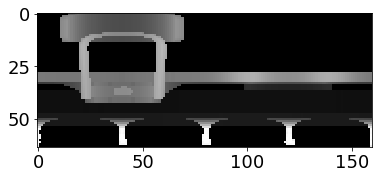

('chair', array([[  3.41381952e-02,   9.19000268e-01,   5.49301447e-04,
           2.40964126e-02,   1.28924763e-02,   4.11937595e-04,
           8.91144853e-03]], dtype=float32))

In [29]:
what_is_this_npy(dataset_test_path + os.sep + 'chair' + os.sep + 'chair_0394.npy')

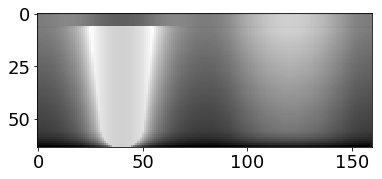

('dresser', array([[  4.05234488e-04,   1.20379671e-03,   6.35052145e-01,
           8.06794688e-03,   1.75198587e-03,   1.60349940e-03,
           3.51915509e-01]], dtype=float32))

In [30]:
what_is_this_npy(dataset_test_path + os.sep + 'toilet' + os.sep + 'toilet_772.npy')

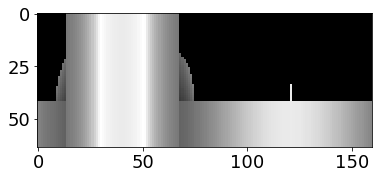

('toilet', array([[  4.17665243e-02,   7.91733712e-03,   4.51931451e-03,
           2.91509763e-03,   4.29915817e-04,   2.21019285e-03,
           9.40241694e-01]], dtype=float32))

In [31]:
what_is_this_npy(dataset_test_path + os.sep + 'toilet' + os.sep + 'toilet_0380.npy')